# PCA QAOA

In this notebook we explore dimensionality reduction methods to train QAOA angles. We use a principal component analysis (PCA) inspired from Ref. [1]. PCA is a dimensionality reduction method that allows us to expose a smaller number of parameters to the optimizer and therefore train faster.

### References

[1] O. Parry and P. McMinn, "QAOA-PCA: Enhancing Efficiency in the Quantum Approximate Optimization Algorithm via Principal Component Analysis" [arXiv:2504.16755](https://arxiv.org/abs/2504.16755)


In [1]:
import matplotlib.pyplot as plt
import networkx as nx

from qaoa_training_pipeline.training import TQATrainer, ScipyTrainer
from qaoa_training_pipeline.evaluation import StatevectorEvaluator
from qaoa_training_pipeline.utils.graph_utils import graph_to_operator

First, we generate a small database of a few good angles for a set of Erdos-Renyi graphs.

In [2]:
trainer1 = TQATrainer(StatevectorEvaluator())
trainer2 = ScipyTrainer(StatevectorEvaluator())

In [3]:
num_instances = 5
qaoa_depth = 4
num_nodes = 8

instances, results = [], []

for idx in range(num_instances):
    instances.append(nx.erdos_renyi_graph(n=num_nodes, p=0.5, seed=idx))
    cost_op = graph_to_operator(instances[-1], pre_factor=-0.5)

    result1 = trainer1.train(cost_op, reps=qaoa_depth)
    result2 = trainer2.train(cost_op, params0=result1["optimized_params"])

    results.append(result2["optimized_params"])

Next, we initialize a PCA trainer that will fit the data to a smaller number of principal coefficient than there are QAOA angles.

In [4]:
from qaoa_training_pipeline.training import QAOAPCA
from qaoa_training_pipeline.training.data_loading import TrivialDataLoader

In [5]:
data_loader = TrivialDataLoader(results)
num_components = 2

pca_trainer = QAOAPCA(data_loader, num_components=num_components, evaluator=StatevectorEvaluator())

The principal componants are stored in the angles function to convert back and forth between QAOA angles and principal components.

In [6]:
pca_trainer.qaoa_angles_function.to_config().keys()

dict_keys(['function_name', 'num_components', 'scaler', 'pca'])

We can obtaine QAOA angles from the principal components. For example, if the value of the principal components is `(0, 0)` then we can obtain the corresponding QAOA as follows.

In [7]:
pca_trainer.qaoa_angles_function([0, 0])

array([ 1.41273081,  0.38517241,  0.33409849,  0.19015328, -0.37382269,
        0.78076997,  0.71026949,  0.91275058])

Now, we generate a new graph and train the parameters using the PCA trainer. We will compare the result to a standard trainer.

In [8]:
new_graph = nx.erdos_renyi_graph(n=num_nodes, p=0.5, seed=2*num_instances)
new_cost_op = graph_to_operator(new_graph, pre_factor=-0.5)

In [9]:
pca_result = pca_trainer.train(new_cost_op, params0=[0]*num_components)

In [10]:
result1 = trainer1.train(new_cost_op, reps=qaoa_depth)
result2 = trainer2.train(new_cost_op, params0=result1["optimized_params"])

We see from the results below that the PCA trainer achieves almost identical energy values to a standard SciPy trainer applied directly to the QAOA angles but in a fraction of the number of iterations. 

Text(0.5, 1.0, 'Standard trainer, best energy: 2.88')

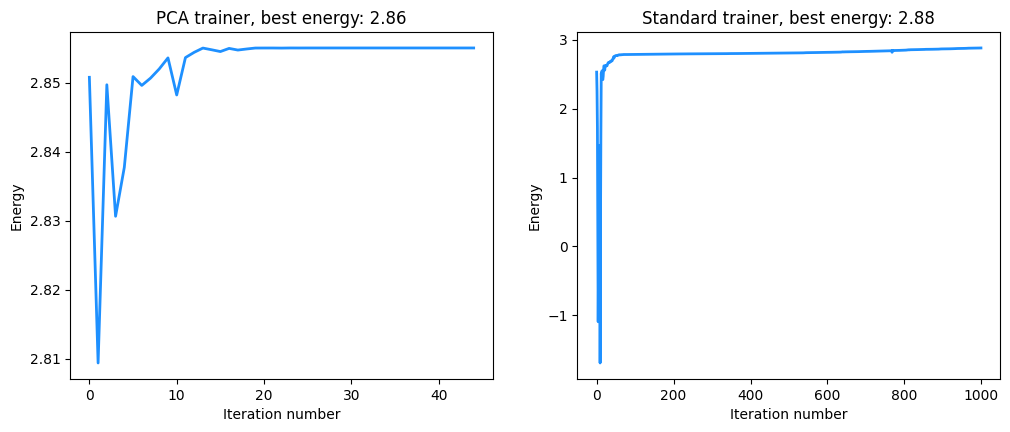

In [11]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4.5))
pca_trainer.plot(fig=fig, axis=axis[0])
trainer2.plot(fig=fig, axis=axis[1])
axis[0].set_title(f"PCA trainer, best energy: {pca_result['energy']:.2f}")
axis[1].set_title(f"Standard trainer, best energy: {result2['energy']:.2f}")